In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import asyncio
import time

# sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import dump_svmlight_file

# tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam

# create plots
import matplotlib.pyplot as plt

# load dataframes
probe = pkl.load(open('./pkl/probe_.pkl', 'rb'))
probe.info()
print('_'*50)
ts = pkl.load(open('./pkl/trainingSet_.pkl', 'rb')) # 20.01 s, 9G
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2817131 entries, 0 to 2817130
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   CustomerID  object
 1   Date        object
 2   MovieID     int64 
dtypes: int64(1), object(2)
memory usage: 64.5+ MB
__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100480507 entries, 0 to 100480506
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   CustomerID  int32 
 1   Rating      int32 
 2   Date        object
 3   MovieID     int32 
dtypes: int32(3), object(1)
memory usage: 1.9+ GB


In [2]:
probe

,CustomerID,Date,MovieID
0,1046323,2005-12-19,1
1,1080030,2005-12-23,1
2,1830096,2005-03-14,1
3,368059,2005-05-26,1
4,802003,2005-11-07,1
...,...,...,...
2817126,1521720,2005-12-07,9998
2817127,1363704,2005-10-01,9998
2817128,2153561,2005-11-15,9999
2817129,1490137,2005-12-22,9999


In [3]:
ts

,CustomerID,Rating,Date,MovieID
0,1488844,3,2005-09-06,1
1,822109,5,2005-05-13,1
2,885013,4,2005-10-19,1
3,30878,4,2005-12-26,1
4,823519,3,2004-05-03,1
...,...,...,...,...
100480502,1790158,4,2005-11-01,17770
100480503,1608708,3,2005-07-19,17770
100480504,234275,1,2004-08-07,17770
100480505,255278,4,2004-05-28,17770


In [4]:
# concat
# concatCustomerID = concat.CustomerID.astype('category').cat.codes.values
# concatMovieID = concat.MovieID.astype('category').cat.codes.values
# ts['catCustomerID'] = concatCustomerID[:ts.shape[0]]
# probe['catCustomerID'] = concatCustomerID[ts.shape[0]:]
# ts['catMovieID'] = concatMovieID[:ts.shape[0]]
# probe['catMovieID'] = concatMovieID[ts.shape[0]:]
# del concat


In [4]:
# train, test = train_test_split(ts, test_size=0.2)
# pkl.dump(train, open('NN_train.pkl', 'wb'))
# pkl.dump(test, open('NN_test.pkl', 'wb'))
# pkl.dump(probe, open('NN_probe.pkl', 'wb'))
train = pkl.load(open('./pkl/NN_train.pkl', 'rb'))
test = pkl.load(open('./pkl/NN_test.pkl', 'rb'))
probe = pkl.load(open('./pkl/NN_probe.pkl', 'rb'))

In [8]:
# concat = pd.concat([ts, probe])
# nCustomer, nMovie = len(concat.CustomerID.unique()), len(concat.MovieID.unique())
# del concat

In [5]:
nCustomer, nMovie =(958804, 17770)

# latent vector size 10

In [10]:
nLatentFactor = 10

movieInput = keras.layers.Input(shape=[1],name='movie')
movieEmbedding10 = keras.layers.Embedding(nMovie, nLatentFactor, name='movieEmbedding', 
                                        embeddings_regularizer = keras.regularizers.l2(1e-5))(movieInput)
movieBias10 = keras.layers.Embedding(nMovie, 1, name='movieBias',
                                   embeddings_regularizer = keras.regularizers.l2(1e-5))(movieInput)
movieVec10 = keras.layers.Flatten(name='flattenMovie')(movieEmbedding10)

customerInput = keras.layers.Input(shape=[1],name='customer')
customerEmbedding10 = keras.layers.Embedding(nCustomer, nLatentFactor,name='customerEmbedding', 
                                           embeddings_regularizer = keras.regularizers.l2(1e-5))(customerInput)
customerBias10 = keras.layers.Embedding(nCustomer, 1, name='customerBias', 
                                      embeddings_regularizer = keras.regularizers.l2(1e-5))(customerInput)
customerVec10 = keras.layers.Flatten(name='flattenCustomer')(customerEmbedding10)
 
iProduct10 = keras.layers.dot([customerVec10, movieVec10], axes=1,name='innerProduct')
add10 = keras.layers.add([iProduct10, movieBias10, customerBias10], name='add')
model10 = keras.Model([customerInput, movieInput], add10)

model10.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
model10.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
customer (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
customerEmbedding (Embedding)   (None, 1, 10)        9588040     customer[0][0]                   
__________________________________________________________________________________________________
movieEmbedding (Embedding)      (None, 1, 10)        177700      movie[0][0]                      
_______________________________________________________________________________________

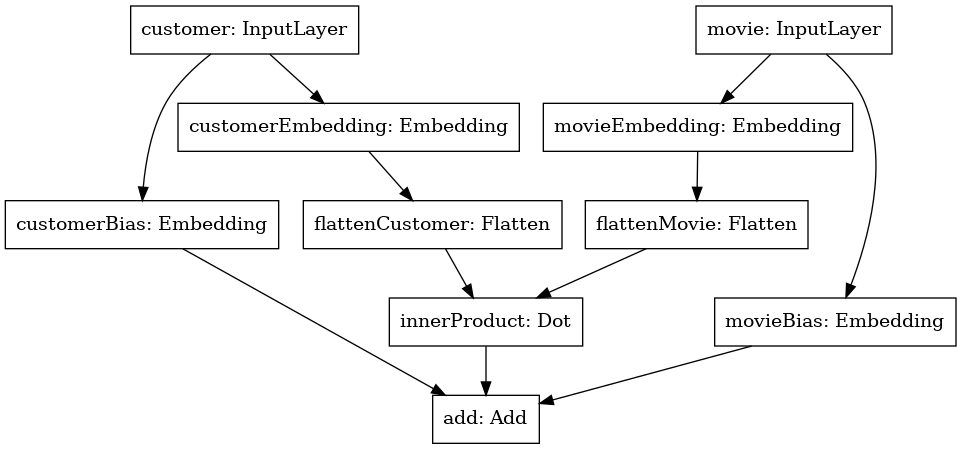

In [11]:
tf.keras.utils.plot_model(model10, to_file='model10.png')

In [12]:
history10 = model10.fit([train.catCustomerID, train.catMovieID], train.Rating, 
                     batch_size=16384, 
                     epochs=40)

Epoch 1/40


/home/bonzo/venv/nn/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


4907/4907 [==============================] - 228s 46ms/step - loss: 4.1667 - mae: 1.3274 - mse: 3.0089
Epoch 2/40
4907/4907 [==============================] - 228s 46ms/step - loss: 2.1157 - mae: 0.8966 - mse: 1.2918
Epoch 3/40
4907/4907 [==============================] - 229s 47ms/step - loss: 1.8635 - mae: 0.8617 - mse: 1.1988
Epoch 4/40
4907/4907 [==============================] - 229s 47ms/step - loss: 1.8563 - mae: 0.8543 - mse: 1.1784
Epoch 5/40
4907/4907 [==============================] - 229s 47ms/step - loss: 1.8562 - mae: 0.8530 - mse: 1.1748
Epoch 6/40
4907/4907 [==============================] - 229s 47ms/step - loss: 1.8561 - mae: 0.8527 - mse: 1.1741
Epoch 7/40
4907/4907 [==============================] - 229s 47ms/step - loss: 1.8560 - mae: 0.8527 - mse: 1.1739
Epoch 8/40
4907/4907 [==============================] - 229s 47ms/step - loss: 1.8558 - mae: 0.8526 - mse: 1.1738
Epoch 9/40
4907/4907 [==============================] - 229s 47ms/step - loss: 1.8557 - mae: 0.8526

In [6]:
# model10.save('model10')
# pkl.dump(pd.DataFrame(history10.history), open('./pkl/history10.pkl', 'wb'))
model10 = keras.models.load_model('model10')
history10 = pkl.load(open('./pkl/history10.pkl', 'rb'))

Text(0, 0.5, 'Training Error')

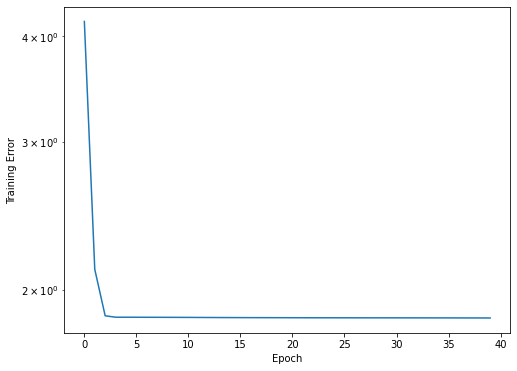

In [7]:
pd.Series(history10['loss']).plot(logy=True, figsize=(8, 6))
plt.xlabel("Epoch")
plt.ylabel("Training Error")

In [8]:
loss10 = model10.evaluate([test.catCustomerID, test.catMovieID], test.Rating, batch_size=32768)

614/614 [==============================] - 14s 23ms/step - loss: 1.8531 - mean_absolute_error: 0.8520 - mean_squared_error: 1.1729


In [9]:
resultProbe10 = model10.predict([probe.catCustomerID, probe.catMovieID], batch_size=32768)

In [10]:
probe['Rating10'] = resultProbe10.reshape((-1,))
probe
pkl.dump(probe, open('./pkl/probe_10.pkl', 'wb'))

,CustomerID,Date,MovieID,catCustomerID,catMovieID,Rating10
0,1046323,2005-12-19,1,489341,0,1.251595
1,1080030,2005-12-23,1,496143,0,1.251595
2,1830096,2005-03-14,1,646536,0,1.251595
3,368059,2005-05-26,1,831469,0,1.251595
4,802003,2005-11-07,1,919001,0,1.251595
...,...,...,...,...,...,...
2817126,1521720,2005-12-07,9998,584675,9997,0.326621
2817127,1363704,2005-10-01,9998,552973,9997,0.326621
2817128,2153561,2005-11-15,9999,711195,9998,0.203228
2817129,1490137,2005-12-22,9999,578166,9998,0.203228


In [11]:
movie_embedding_learnt = model10.get_layer(name='movieEmbedding').get_weights()[0]
pd.set_option('precision', 2)
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2,3,4,5,6,7,8,9
count,17770.00,1.78e+04,1.78e+04,1.78e+04,1.78e+04,1.78e+04,1.78e+04,1.78e+04,1.78e+04,1.78e+04
mean,-0.05,7.81e-03,5.02e-05,-5.64e-03,-5.02e-05,-5.02e-05,1.36e-02,5.02e-05,3.86e-03,-5.02e-05
std,0.33,6.62e-02,1.66e-03,4.97e-02,1.66e-03,1.66e-03,1.07e-01,1.66e-03,2.18e-02,1.66e-03
min,-3.84,-6.16e-01,-1.48e-02,-9.18e-01,-1.73e-02,-1.73e-02,-9.59e-01,-1.48e-02,-6.94e-02,-1.73e-02
25%,-0.02,-1.34e-02,-4.20e-04,-3.90e-03,-4.61e-04,-4.62e-04,-2.03e-02,-4.20e-04,-4.90e-03,-4.61e-04
50%,0.01,-3.57e-03,8.15e-09,2.36e-03,-8.15e-09,-7.94e-09,-6.39e-03,8.15e-09,-7.96e-04,-8.15e-09
75%,0.05,4.51e-03,4.61e-04,1.03e-02,4.20e-04,4.20e-04,5.90e-03,4.61e-04,2.65e-03,4.20e-04
max,1.76,1.22e+00,1.73e-02,4.70e-01,1.48e-02,1.48e-02,1.97e+00,1.73e-02,3.12e-01,1.48e-02


# latent vector size 20

In [12]:
nLatentFactor = 20

movieInput = keras.layers.Input(shape=[1],name='movie')
movieEmbedding20 = keras.layers.Embedding(nMovie, nLatentFactor, name='movieEmbedding', 
                                        embeddings_regularizer = keras.regularizers.l2(1e-5))(movieInput)
movieBias20 = keras.layers.Embedding(nMovie, 1, name='movieBias',
                                   embeddings_regularizer = keras.regularizers.l2(1e-5))(movieInput)
movieVec20 = keras.layers.Flatten(name='flattenMovie')(movieEmbedding20)

customerInput = keras.layers.Input(shape=[1],name='customer')
customerEmbedding20 = keras.layers.Embedding(nCustomer, nLatentFactor,name='customerEmbedding', 
                                           embeddings_regularizer = keras.regularizers.l2(1e-5))(customerInput)
customerBias20 = keras.layers.Embedding(nCustomer, 1, name='customerBias', 
                                      embeddings_regularizer = keras.regularizers.l2(1e-5))(customerInput)
customerVec20 = keras.layers.Flatten(name='flattenCustomer')(customerEmbedding20)
 
iProduct20 = keras.layers.dot([customerVec20, movieVec20], axes=1,name='innerProduct')
add20 = keras.layers.add([iProduct20, movieBias20, customerBias20], name='add')
model20 = keras.Model([customerInput, movieInput], add20)

model20.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
model20.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
customer (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
customerEmbedding (Embedding)   (None, 1, 20)        19176080    customer[0][0]                   
__________________________________________________________________________________________________
movieEmbedding (Embedding)      (None, 1, 20)        355400      movie[0][0]                      
_______________________________________________________________________________________

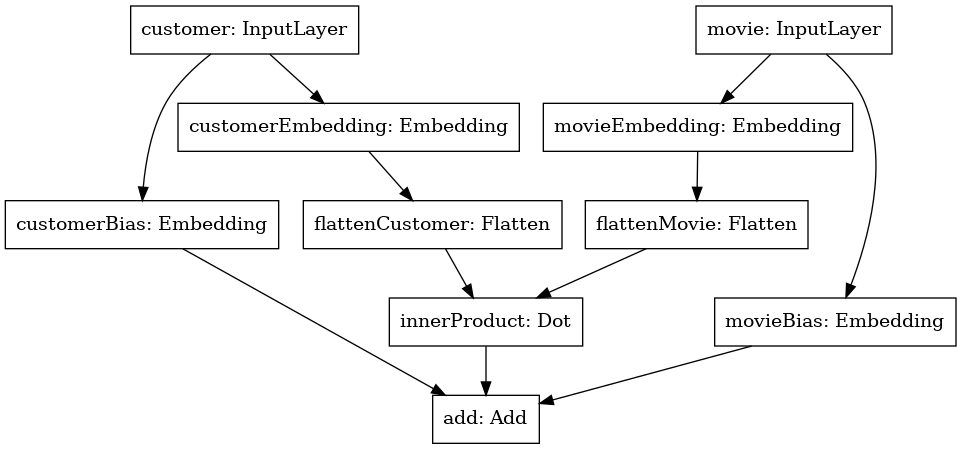

In [13]:
tf.keras.utils.plot_model(model20, to_file='model20.png')

In [14]:
history20 = model20.fit([train.catCustomerID, train.catMovieID], train.Rating, 
                     batch_size=16384, 
                     epochs=40)

Epoch 1/40


/home/bonzo/venv/nn/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


4907/4907 [==============================] - 438s 89ms/step - loss: 4.0654 - mae: 1.2771 - mse: 2.8185
Epoch 2/40
4907/4907 [==============================] - 439s 89ms/step - loss: 2.1042 - mae: 0.8972 - mse: 1.2927
Epoch 3/40
4907/4907 [==============================] - 439s 89ms/step - loss: 1.8621 - mae: 0.8578 - mse: 1.1894
Epoch 4/40
4907/4907 [==============================] - 439s 89ms/step - loss: 1.8579 - mae: 0.8536 - mse: 1.1768
Epoch 5/40
4907/4907 [==============================] - 440s 90ms/step - loss: 1.8573 - mae: 0.8532 - mse: 1.1752
Epoch 6/40
4907/4907 [==============================] - 439s 90ms/step - loss: 1.8568 - mae: 0.8529 - mse: 1.1745
Epoch 7/40
4907/4907 [==============================] - 439s 90ms/step - loss: 1.8564 - mae: 0.8528 - mse: 1.1742
Epoch 8/40
4907/4907 [==============================] - 439s 90ms/step - loss: 1.8559 - mae: 0.8526 - mse: 1.1738
Epoch 9/40
4907/4907 [==============================] - 440s 90ms/step - loss: 1.8555 - mae: 0.8525

In [2]:
# model20 = keras.models.load_model('model20')
# history20 = pkl.load(open('./pkl/history20.pkl', 'rb'))
model20.save('model20')
pkl.dump(pd.DataFrame(history20.history), open('./pkl/history20.pkl', 'wb'))

Text(0, 0.5, 'Training Error')

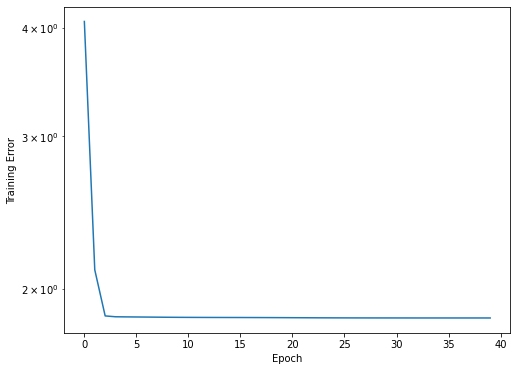

In [17]:
pd.Series(history20.history['loss']).plot(logy=True, figsize=(8, 6))
plt.xlabel("Epoch")
plt.ylabel("Training Error")

In [5]:
loss20 = model20.evaluate([test.catCustomerID, test.catMovieID], test.Rating, batch_size=32768)

614/614 [==============================] - 28s 45ms/step - loss: 1.8526 - mean_absolute_error: 0.8517 - mean_squared_error: 1.1723


In [ ]:
resultProbe20 = model20.predict([probe.catCustomerID, probe.catMovieID], batch_size=32768)

In [25]:
probe['Rating20'] = resultProbe20.reshape((-1,))
pkl.dump(probe, open('./pkl/probe_20.pkl', 'wb'))
probe

,CustomerID,Date,MovieID,catCustomerID,catMovieID,Rating10,Rating20
0,1046323,2005-12-19,1,489341,0,1.25,1.24
1,1080030,2005-12-23,1,496143,0,1.25,1.24
2,1830096,2005-03-14,1,646536,0,1.25,1.24
3,368059,2005-05-26,1,831469,0,1.25,1.24
4,802003,2005-11-07,1,919001,0,1.25,1.24
...,...,...,...,...,...,...,...
2817126,1521720,2005-12-07,9998,584675,9997,0.33,0.32
2817127,1363704,2005-10-01,9998,552973,9997,0.33,0.32
2817128,2153561,2005-11-15,9999,711195,9998,0.20,0.21
2817129,1490137,2005-12-22,9999,578166,9998,0.20,0.21


In [21]:
movie_embedding_learnt = model20.get_layer(name='movieEmbedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,1.78e+04,1.78e+04,1.78e+04,1.78e+04,1.78e+04,1.78e+04,1.78e+04,1.78e+04,1.78e+04,1.78e+04,1.78e+04,1.78e+04,1.78e+04,1.78e+04,1.78e+04,1.78e+04,1.78e+04,1.78e+04,17770.00,1.78e+04
mean,-6.47e-05,-1.51e-02,6.47e-05,6.47e-05,-6.47e-05,6.47e-05,6.47e-05,-6.47e-05,-6.47e-05,6.47e-05,6.47e-05,-6.47e-05,6.47e-05,-6.47e-05,6.47e-05,-6.47e-05,-5.97e-05,-4.73e-03,0.05,-6.47e-05
std,1.34e-03,1.31e-01,1.34e-03,1.34e-03,1.34e-03,1.34e-03,1.34e-03,1.34e-03,1.34e-03,1.34e-03,1.34e-03,1.34e-03,1.34e-03,1.34e-03,1.34e-03,1.34e-03,1.39e-03,4.85e-02,0.33,1.34e-03
min,-1.10e-02,-2.41e+00,-1.06e-02,-1.06e-02,-1.10e-02,-1.06e-02,-1.06e-02,-1.10e-02,-1.10e-02,-1.06e-02,-1.06e-02,-1.10e-02,-1.06e-02,-1.10e-02,-1.06e-02,-1.10e-02,-1.15e-02,-8.74e-01,-1.69,-1.10e-02
25%,-4.16e-04,-6.95e-03,-3.40e-04,-3.40e-04,-4.17e-04,-3.40e-04,-3.40e-04,-4.17e-04,-4.17e-04,-3.40e-04,-3.40e-04,-4.17e-04,-3.40e-04,-4.17e-04,-3.40e-04,-4.17e-04,-4.18e-04,-3.78e-03,-0.05,-4.17e-04
50%,-4.73e-08,7.85e-03,4.91e-08,4.91e-08,-4.91e-08,4.91e-08,4.91e-08,-4.91e-08,-4.91e-08,4.91e-08,4.91e-08,-4.91e-08,4.90e-08,-4.91e-08,4.91e-08,-4.91e-08,-1.98e-08,2.27e-03,-0.02,-4.91e-08
75%,3.40e-04,2.43e-02,4.17e-04,4.17e-04,3.40e-04,4.17e-04,4.17e-04,3.40e-04,3.40e-04,4.17e-04,4.17e-04,3.40e-04,4.16e-04,3.40e-04,4.17e-04,3.40e-04,3.62e-04,1.01e-02,0.02,3.40e-04
max,1.06e-02,1.34e+00,1.10e-02,1.10e-02,1.06e-02,1.10e-02,1.10e-02,1.06e-02,1.06e-02,1.10e-02,1.10e-02,1.06e-02,1.10e-02,1.06e-02,1.10e-02,1.06e-02,1.06e-02,5.37e-01,3.82,1.06e-02


In [8]:
probe = probe[['CustomerID', 'Date', 'MovieID', 'Rating20']]
probe.columns = ['CustomerID', 'Date', 'MovieID', 'Rating']
probe.to_csv('probe_NN.csv')